In [1]:
import os
from dotenv import load_dotenv
# from google.colab import drive

# drive.mount('/content/drive')

try:
    import google.colab
    print("Colab 환경에서 실행 중입니다.")
    PATH = '/content/drive/MyDrive/data/'
    env_path = PATH + "env/.env"
except ImportError:
    print("로컬 환경에서 실행 중입니다.")
    import platform
    os_name = platform.system()
    if os_name == "Windows":
        print("Windows 로컬 환경에서 실행 중입니다.")
        PATH = './'
        env_path = PATH + "env/.env"
    elif os_name == "Linux":
        print("Linux 환경에서 실행 중입니다. (Colab일 가능성 있음)")
    else:
        print(f"운영 체제: {os_name}")

load_dotenv(dotenv_path=env_path)

# getenv로 환경 변수 가져오기
# KEY 쓸 때, 띄워쓰기 하면 안됨...
# env에 있는 모든 워드들은 띄워쓰기하면 못 알아봄
api_key = os.getenv('MY_OWN_KEY')

if not api_key:
    raise ValueError(".env 파일에서 API 키를 로드하지 못했습니다.")


# 가져온 값을 environ에 저장
os.environ['OPENAI_API_KEY'] = api_key

로컬 환경에서 실행 중입니다.
Windows 로컬 환경에서 실행 중입니다.


# Graph v1

## State

- add_messages : 기존 메세지가 있으면 update, 없으면 add하는 기능
    - 저장 형식
    ``` python
    {
        "messages": [
            {"role": "user", "content": "안녕하세요"},
            {"role": "assistant", "content": "안녕하세요! 무엇을 도와드릴까요?"},
            # ... 추가 메시지들
        ]
    }
    ```

In [2]:
# state를 만들거임
# 각 노드간 데이터를 전달하는 box 역할
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

## Node

- 노드는 그래프 구조의 기본 구성 요소 중 하나로, **특정 작업을 수행하는 단위**를 나타냅니다.
- LangGraph에서 노드는 언어 모델 호출, 데이터 처리, 입력을 구성하는 등 **하나의 독립된 작업**을 맡고 있습니다.
- 예를 들어, 언어 모델이 특정 질문에 대한 답변을 생성하는 기능을 담당하는 노드를 생성할 수 있습니다.
- 노드의 종류: LLM(언어 모델) 노드, 메모리 노드, 도구 노드 등 다양한 작업별 노드로 나뉘며, 필요에 따라 여러 노드를 서로 연결하여 워크플로우를 구성할 수 있습니다.

In [3]:
# node 만들거임
# 

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [4]:
def chatbot(state:State) -> State:
    return {
        "messages":[
            llm.invoke(
                state["messages"]
            )
        ]
    }

## Create Graph

In [5]:
# Graph 객체 선언
# simple_graph 상 데이터 전달에 사용할 객체 = State 클래스
from langgraph.graph import StateGraph

simple_graph = StateGraph(State)

## Add node

In [6]:
# node를 LangGraph에 추가하기
# add_node("식별명", 생성한 node 명)
# 나중에 egde들이 node를 구별해야 하므로 이를 명시하고 연결시키기 위해 "식별명"이 필수적으로 들어가야 한다.

simple_graph.add_node(
    "simple_chatbot", chatbot
)

## Start node & End node

In [7]:
# 모든 Graph에는 Start와 end node가 필수적으로 필요하다.

# start node
# LangGraph에 추가된 노드들 중에서 맨 처음으로 사용되는 노드 정의
# 해당 예제에선 simple_chatbot이라는 노드, 하나뿐임으로 해당 노드가 start node가 된다.
simple_graph.set_entry_point(
    "simple_chatbot"
)

In [8]:
# end node
# LangGraph에 추가된 노드들 중에서 맨 마지막으로 사용되는 노드 정의
# 해당 예제에선 simple_chatbot이라는 노드, 하나 뿐이므로 해당 노드가 end node가 된다.
simple_graph.set_finish_point(
    "simple_chatbot"
)

## Compile Graph

In [9]:
# complie() 함수를 통해서 객체화(메모리에 올리감)
# 이 이전의 과정은 단순 빌드 과정
# 다르게 말하면 이전 과정들은 프로그램을 실행하기 전에 코드를 짜는 과정
# simple_graph에 추가한(add_node, StateGraph) 것들을 모두 실행하기 위해 메모리에 올리는 과정
compiled_graph = simple_graph.compile()

## Display Graph

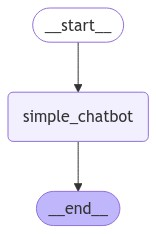

In [10]:
# 현재 확장자가 ipynb이므로 Ipython을 사용한 거임
from IPython.display import Image, display

try:
    display(
        Image(
            compiled_graph.get_graph().draw_mermaid_png()
        )
    )
except:
    pass

## Run Graph
- CallbackHandler
    - LangSmith를 통해 Graph 로깅을 도와주는 객체

In [11]:
from langfuse.callback import CallbackHandler
from langchain_core.messages import HumanMessage
import time
# LangGraph와 LangSmith를 연결하기 위한 객체
langfuse_handler = CallbackHandler()

for chunk in compiled_graph.stream(
    # start node에게 전달할 input data
            {
                "messages":[
                    HumanMessage(content="대한민국의 수도는?")
                ]
            },
            # 로깅 설정 = LangGraph 기록을 LangSmith한테 전달
            config = {
                "callbacks":[langfuse_handler]
            }
        ):
    print(chunk)
    time.sleep(0.05)

Langfuse client is disabled since no public_key was provided as a parameter or environment variable 'LANGFUSE_PUBLIC_KEY'. See our docs: https://langfuse.com/docs/sdk/python/low-level-sdk#initialize-client


{'simple_chatbot': {'messages': [AIMessage(content='대한민국의 수도는 서울입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 13, 'total_tokens': 21, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-032d1638-45f3-4595-b818-ec0e060b46d2-0', usage_metadata={'input_tokens': 13, 'output_tokens': 8, 'total_tokens': 21, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]}}


# Graph v2.1 -> State를 리스트로 선언
- 기본 코드 셋으로는 indexing에 유의가 필요함
- 최신 자료는 [-1]과 같은 indexing을 이용해서 해결

## State

In [12]:
# state를 만들거임
# 각 노드간 데이터를 전달하는 box 역할
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

## Node

In [13]:
def len_str(state:State) -> State:
    input_data = state["messages"][-1].content
    print(input_data)
    result = len(input_data)
    return {
        "messages": [
            HumanMessage(content=str(result))  # 정수를 문자열로 변환하여 메시지 객체로 반환
        ]
    }

In [14]:
def add_one(state:State) -> State:
    input_data = state["messages"][-1].content
    print(input_data)
    result = int(input_data) + 1
    return {
        "messages": [
            HumanMessage(content=str(result))  # 정수를 문자열로 변환하여 메시지 객체로 반환
        ]
    }

In [15]:
# def dis_one(state:State) -> State:
#     input_data = state["messages"][0].content
#     result = int(input_data) - 1
#     return{
#         "messages":[result]
#     }

## Create Graph

In [16]:
from langgraph.graph import StateGraph

simple_graph = StateGraph(State)

## Add node

In [17]:
simple_graph.add_node(
    "len_str", len_str
)

simple_graph.add_node(
    "add_one", add_one
)
# # 사용 안하는 노드 들어가면 에러 뜸
# simple_graph.add_node(
#     "dis_one", dis_one
# )

## Add Edge

In [18]:
from langgraph.graph import START, END

### Start node & end node

In [19]:
# Edge를 이용해서 Start node를 선정할 수 있다.
# 또한 간편하게 START로 선언함
# __stert__ -> len_str
simple_graph.add_edge(
    START,"len_str"
)
# "add_one" -> __end__
simple_graph.add_edge(
    "add_one", END
)

### Combine nodes

In [20]:
# node끼리 연결해보기
# len_str -> add_one
simple_graph.add_edge(
    "len_str", "add_one"
)

## Compile graph

In [21]:
compiled_graph = simple_graph.compile()

## Display graph

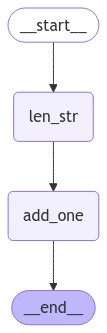

In [22]:
# 현재 확장자가 ipynb이므로 Ipython을 사용한 거임
from IPython.display import Image, display

try:
    display(
        Image(
            compiled_graph.get_graph().draw_mermaid_png()
        )
    )
except:
    pass

## Run Graph

In [23]:

# LangGraph와 LangSmith를 연결하기 위한 객체
langfuse_handler = CallbackHandler()

for chunk in compiled_graph.stream(
    # start node에게 전달할 input data
            {
                "messages":[
                    HumanMessage(content="Hellow world! my life for own life")
                ]
            },
            # # 로깅 설정 = LangGraph 기록을 LangSmith한테 전달
            # config = {
            #     "callbacks":[langfuse_handler]
            # }
        ):
    print(chunk)

Langfuse client is disabled since no public_key was provided as a parameter or environment variable 'LANGFUSE_PUBLIC_KEY'. See our docs: https://langfuse.com/docs/sdk/python/low-level-sdk#initialize-client


Hellow world! my life for own life
{'len_str': {'messages': [HumanMessage(content='34', additional_kwargs={}, response_metadata={}, id='4016be41-8ffb-4dfb-937c-d013998befe2')]}}
34
{'add_one': {'messages': [HumanMessage(content='35', additional_kwargs={}, response_metadata={}, id='964f11c8-6908-4857-b42d-28e0d487e32e')]}}


# Graph v2.2 -> State 일반 자료형 선언
- 과거 데이터를 버리고 계속해서 자료를 갱신함
- 단, 과거 데이터를 버리기 때문에 기억할 공간을 새로 만들 필요가 있음

## State

In [24]:
# state를 만들거임
# 각 노드간 데이터를 전달하는 box 역할
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    input: str
    result: int

## Node

In [25]:
def len_str(state:State) -> State:
    input_data = state["input"]
    result = len(input_data)
    return {
        "input": input_data,  # 원래 입력값 유지
        "result": result  # 단순 정수값 반환
    }

# 이전 결과물 
# {'len_str': {'result': 33}}

In [26]:
def add_one(state:State) -> State:
    input_data = state["result"]
    result = int(input_data) + 1
    return {
        "input": state["input"],  # 원래 입력값 유지
        "result": result  # 단순 정수값 반환
    }

# 이전 결과물
# {'add_one': {'result': 34}}

In [27]:
# def dis_one(state:State) -> State:
#     input_data = state["messages"][0].content
#     result = int(input_data) - 1
#     return{
#         "messages":[result]
#     }

## Create Graph

In [28]:
from langgraph.graph import StateGraph

simple_graph = StateGraph(State)

## Add node

In [29]:
simple_graph.add_node(
    "len_str", len_str
)

simple_graph.add_node(
    "add_one", add_one
)
# # 쓸데 없는 노드 들어가면 에러 뜸뜸
# simple_graph.add_node(
#     "dis_one", dis_one
# )

## Add Edge

In [30]:
from langgraph.graph import START, END

### Start node & end node

In [31]:
# Edge를 이용해서 Start node를 선정할 수 있다.
# 또한 간편하게 START로 선언함
# __stert__ -> len_str
simple_graph.add_edge(
    START,"len_str"
)
# "add_one" -> __end__
simple_graph.add_edge(
    "add_one", END
)

### Combine nodes

In [32]:
# node끼리 연결해보기
# len_str -> add_one
simple_graph.add_edge(
    "len_str", "add_one"
)

## Compile graph

In [33]:
compiled_graph = simple_graph.compile()

## Display graph

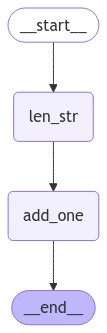

In [34]:
# 현재 확장자가 ipynb이므로 Ipython을 사용한 거임
from IPython.display import Image, display

try:
    display(
        Image(
            compiled_graph.get_graph().draw_mermaid_png()
        )
    )
except:
    pass

## Run Graph

In [35]:

# LangGraph와 LangSmith를 연결하기 위한 객체
langfuse_handler = CallbackHandler()

for chunk in compiled_graph.stream(
    # start node에게 전달할 input data
            {
            "input": "Hello world! my life for own life",
            "result": 0  # 초기값 설정
            },
            # # 로깅 설정 = LangGraph 기록을 LangSmith한테 전달
            # config = {
            #     "callbacks":[langfuse_handler]
            # }
        ):
    print(chunk)

Langfuse client is disabled since no public_key was provided as a parameter or environment variable 'LANGFUSE_PUBLIC_KEY'. See our docs: https://langfuse.com/docs/sdk/python/low-level-sdk#initialize-client


{'len_str': {'input': 'Hello world! my life for own life', 'result': 33}}
{'add_one': {'input': 'Hello world! my life for own life', 'result': 34}}


# Graph v2 예제

## State

In [36]:
# state를 만들거임
# 각 노드간 데이터를 전달하는 box 역할
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

## Node

In [37]:
def len_str(state:State) -> State:
    input_data = state["messages"][-1].content
    result = len(input_data)
    return {
        "messages": [
            HumanMessage(content=str(result))  # 정수를 문자열로 변환하여 메시지 객체로 반환
        ]
    }

In [38]:
def add_one(state:State) -> State:
    input_data = state["messages"][-1].content
    result = int(input_data) + 1
    return {
        "messages": [
            HumanMessage(content=str(result))  # 정수를 문자열로 변환하여 메시지 객체로 반환
        ]
    }

In [39]:
def dis_one(state:State) -> State:
    input_data = state["messages"][-1].content
    result = int(input_data) - 1
    return{
        "messages": HumanMessage(content=str(result))
    }

In [40]:
def cross_two(state:State) -> State:
    input_data = state["messages"][-1].content
    result = int(input_data) * 2
    return {
        "messages": HumanMessage(content=str(result))
    }

## Create Graph

In [41]:
from langgraph.graph import StateGraph

simple_graph = StateGraph(State)

## Add node

In [42]:
simple_graph.add_node(
    "len_str", len_str
)

simple_graph.add_node(
    "add_one", add_one
)
# 사용 안하는 노드 들어가면 에러 뜸
simple_graph.add_node(
    "dis_one", dis_one
)

simple_graph.add_node(
    "cross_two", cross_two
)

## Add Edge

In [43]:
from langgraph.graph import START, END

### Start node & end node

In [44]:
# Edge를 이용해서 Start node를 선정할 수 있다.
# 또한 간편하게 START로 선언함
# __stert__ -> len_str
simple_graph.add_edge(
    START,"len_str"
)
# "add_one" -> __end__
simple_graph.add_edge(
    "cross_two", END
)

### Combine nodes

In [45]:
# node끼리 연결해보기
# len_str -> add_one
simple_graph.add_edge(
    "len_str", "add_one"
)
simple_graph.add_edge(
    "add_one", "dis_one"
)
simple_graph.add_edge(
    "dis_one", "cross_two"
)

## Compile graph

In [46]:
compiled_graph = simple_graph.compile()

## Display graph

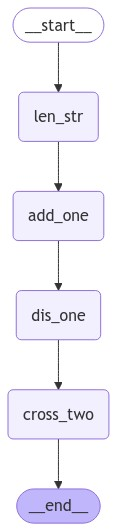

In [47]:
# 현재 확장자가 ipynb이므로 Ipython을 사용한 거임
from IPython.display import Image, display

try:
    display(
        Image(
            compiled_graph.get_graph().draw_mermaid_png()
        )
    )
except:
    pass

## Run Graph

In [48]:

# LangGraph와 LangSmith를 연결하기 위한 객체
langfuse_handler = CallbackHandler()

for chunk in compiled_graph.stream(
    # start node에게 전달할 input data
            {
                "messages":[
                    HumanMessage(content="Hellow world! my life for own life")
                ]
            },
            # # 로깅 설정 = LangGraph 기록을 LangSmith한테 전달
            # config = {
            #     "callbacks":[langfuse_handler]
            # }
        ):
    print(chunk)

Langfuse client is disabled since no public_key was provided as a parameter or environment variable 'LANGFUSE_PUBLIC_KEY'. See our docs: https://langfuse.com/docs/sdk/python/low-level-sdk#initialize-client


{'len_str': {'messages': [HumanMessage(content='34', additional_kwargs={}, response_metadata={}, id='b4b25be8-7814-4e8b-9143-ace06f25732e')]}}
{'add_one': {'messages': [HumanMessage(content='35', additional_kwargs={}, response_metadata={}, id='9a530edf-af2c-437f-b553-f29c6bd900e9')]}}
{'dis_one': {'messages': HumanMessage(content='34', additional_kwargs={}, response_metadata={}, id='0d54cd26-bb46-41ab-9b6a-2fa55dff8455')}}
{'cross_two': {'messages': HumanMessage(content='68', additional_kwargs={}, response_metadata={}, id='eb348db4-594a-48a7-9600-01fa95709fe7')}}


# Graph v3 - if문으로 분기 만들기

## State

In [49]:
# state를 만들거임
# 각 노드간 데이터를 전달하는 box 역할
from typing import Annotated
from typing_extensions import TypedDict, Optional
from langgraph.graph.message import add_messages

class State(TypedDict):
    input: Optional[str] = None
    node_output: Optional[int] = None
    is_stop: Optional[bool] = False

## Node

In [50]:
def len_str(state:State) -> State:
    input = state["input"]
    result = len(input)
    return {
        **state, # 기존의 state의 모든 값을 호출 -> 호출한 input에 변경된 node_output을 갱신할려면 이렇게 리턴해야 함 아니면 변경된 node_output만 리턴함
        "node_output":result,
        "is_stop": False
    }

def add_one(state:State) -> State:
    input = state["node_output"]
    is_stop = state['is_stop']
    result = input + 1
    if result > 10:
        is_stop = True
    return {
        **state,
        "node_output":result,
        "is_stop": is_stop
    }

def add_two(state:State) -> State:
    input = state["node_output"]
    is_stop = state['is_stop']
    result = input + 2
    if result > 10:
        is_stop = True
    return {
        **state,
        "node_output":result,
        "is_stop": is_stop
    }

## Create Graph

In [51]:
simple_graph = StateGraph(State)

## Add node

In [52]:
simple_graph.add_node(
    "len_str", len_str
)
simple_graph.add_node(
    "add_one", add_one
)
simple_graph.add_node(
    "add_two", add_two
)

## Create Edge (add conditional edge)

In [53]:
# 분기가 되는 노드를 생성
def is_stop(state:State) -> str:
    is_stop = state['is_stop']
    if is_stop:
        return "go_to_stop"
    else:
        return "go_to_add_two_func"

In [54]:
simple_graph.add_edge(
    START,"len_str"
)
simple_graph.add_edge(
    "len_str", "add_one"
)
# simple_graph.add_edge(
#     "add_one", "stop_state"
# )
simple_graph.add_edge(
    "add_two", "add_one"
)
simple_graph.add_conditional_edges(
    "add_one", # 시작 노드명 호출 -> 위에서 add node로 했던 것
    is_stop, # 조건 def 함수
    # 변수의 결과에 따라 어떻게 되는지 아래의 룰을 따름
    {
        "go_to_add_two_func":"add_two",
        "go_to_stop":END
    }
)
simple_graph.add_edge(
    "add_two", "add_one"
)

## Compile Graph

In [55]:
compiled_graph = simple_graph.compile()

## Display graph

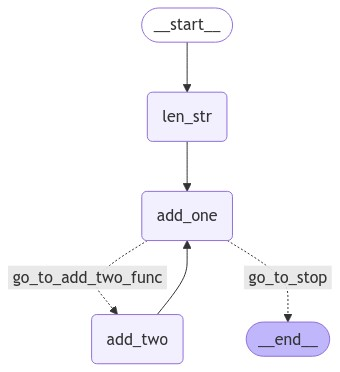

In [56]:
# 현재 확장자가 ipynb이므로 Ipython을 사용한 거임
from IPython.display import Image, display

try:
    display(
        Image(
            compiled_graph.get_graph().draw_mermaid_png()
        )
    )
except:
    pass

## Run Graph

In [58]:
# LangGraph와 LangSmith를 연결하기 위한 객체
langfuse_handler = CallbackHandler()

for chunk in compiled_graph.stream(
            # State 클래스 형식에 맞게 입력 데이터 구성
            {
                "input": "Hello"
            },
            # # 로깅 설정 = LangGraph 기록을 LangSmith한테 전달
            # config = {
            #     "callbacks":[langfuse_handler]
            # }
        ):
    print(chunk)

Langfuse client is disabled since no public_key was provided as a parameter or environment variable 'LANGFUSE_PUBLIC_KEY'. See our docs: https://langfuse.com/docs/sdk/python/low-level-sdk#initialize-client


{'len_str': {'input': 'Hello', 'node_output': 5, 'is_stop': False}}
{'add_one': {'input': 'Hello', 'node_output': 6, 'is_stop': False}}
{'add_two': {'input': 'Hello', 'node_output': 8, 'is_stop': False}}
{'add_one': {'input': 'Hello', 'node_output': 9, 'is_stop': False}}
{'add_two': {'input': 'Hello', 'node_output': 11, 'is_stop': True}}
{'add_one': {'input': 'Hello', 'node_output': 12, 'is_stop': True}}
